In [1]:

#!pip install pandas numpy matplotlib scipy statsmodels yfinance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import statsmodels.api as sm
import yfinance as yf

UPLOADED_FILE_NAME = 'stockprices.xlsx'
TRADING_DAYS = 252

RISK_FREE_RATE = 0.066413 # avg of tbill rates

In [2]:


try:
    prices_df = pd.read_excel(UPLOADED_FILE_NAME, sheet_name='Sheet1')
    print("Successfully read file as Excel.")
except FileNotFoundError:
    print(f"ERROR: File not found. Please make sure '{UPLOADED_FILE_NAME}' is uploaded to Colab.")
    raise
except Exception as e:
    print(f"Could not read as Excel ({e}). Trying as CSV...")
    try:
        prices_df = pd.read_csv(UPLOADED_FILE_NAME, skipinitialspace=True)
        print("Successfully read file as CSV.")
    except Exception as e2:
        print(f"Also failed to read as CSV: {e2}")
        print("Please check the file and re-upload. Ensure it's a valid Excel or CSV.")
        raise #all this is not really needed, but fine

prices_df.columns = prices_df.columns.str.strip() #strips trailing and leading white spaces from column names

prices_df['Date'] = pd.to_datetime(prices_df['Date']) #whats this doing?

prices_df = prices_df.sort_values(by='Date').set_index('Date') #sorting in ascending order by date

STOCK_COLUMNS = ['Axis Bank', 'Indigo', 'Jubilant', 'JK Cements', 'Fortis']
INDEX_COLUMN = 'Nifty 50'

daily_returns = prices_df.pct_change().dropna() #calculating daily returns in %

print("\nData loaded and daily returns calculated successfully.")
print(daily_returns.head())

Successfully read file as Excel.

Data loaded and daily returns calculated successfully.
            Axis Bank    Indigo  Jubilant  JK Cements    Fortis  Nifty 50
Date                                                                     
2024-04-02  -0.005603  0.005311  0.007365    0.010997 -0.003147 -0.000387
2024-04-03   0.015327 -0.021568  0.004474    0.001824 -0.009238 -0.000831
2024-04-04  -0.000282 -0.001948  0.009886    0.003711  0.004131  0.003566
2024-04-05  -0.003622  0.004449 -0.009251    0.001056  0.026916 -0.000042
2024-04-08   0.016004  0.028647 -0.016938    0.007330 -0.005952  0.006778


In [3]:
avg_daily_returns = daily_returns.mean()
avg_annual_returns = avg_daily_returns * TRADING_DAYS

var_daily = daily_returns.var()
var_annual = var_daily * TRADING_DAYS

std_daily = daily_returns.std()
std_annual = std_daily * np.sqrt(TRADING_DAYS)

print("--- Annualized Statistics ---")
print("Average Annual Returns:")
print(avg_annual_returns.to_markdown(floatfmt=".4f"))
print("\nAnnualized Volatility (Std. Dev.):")
print(std_annual.to_markdown(floatfmt=".4f"))


cov_matrix = daily_returns[STOCK_COLUMNS].cov()
annual_cov_matrix = cov_matrix * TRADING_DAYS

print("\n--- Annualized Covariance Matrix (5 Stocks) ---")
print(annual_cov_matrix.to_markdown(floatfmt=".4f"))

corr_matrix = daily_returns[STOCK_COLUMNS].corr()
print("\n--- Correlation Matrix (5 Stocks) ---")
print(corr_matrix.to_markdown(floatfmt=".2f"))

--- Annualized Statistics ---
Average Annual Returns:
|            |      0 |
|:-----------|-------:|
| Axis Bank  | 0.0757 |
| Indigo     | 0.4166 |
| Jubilant   | 0.4382 |
| JK Cements | 0.1807 |
| Fortis     | 0.5485 |
| Nifty 50   | 0.0566 |

Annualized Volatility (Std. Dev.):
|            |      0 |
|:-----------|-------:|
| Axis Bank  | 0.2434 |
| Indigo     | 0.2997 |
| Jubilant   | 0.3273 |
| JK Cements | 0.2738 |
| Fortis     | 0.3268 |
| Nifty 50   | 0.1407 |

--- Annualized Covariance Matrix (5 Stocks) ---
|            |   Axis Bank |   Indigo |   Jubilant |   JK Cements |   Fortis |
|:-----------|------------:|---------:|-----------:|-------------:|---------:|
| Axis Bank  |      0.0593 |   0.0238 |     0.0176 |       0.0163 |   0.0086 |
| Indigo     |      0.0238 |   0.0898 |     0.0161 |       0.0185 |   0.0157 |
| Jubilant   |      0.0176 |   0.0161 |     0.1071 |       0.0150 |   0.0143 |
| JK Cements |      0.0163 |   0.0185 |     0.0150 |       0.0749 |   0.0241 |
| F


--- Finding 5-Stock Tangency Portfolio ---
Tangency Portfolio (Max Sharpe Ratio):
  Return: 0.4772
  Volatility: 0.2125
  Sharpe Ratio: 1.9336

Optimal Weights:
  Axis Bank: 0.00%
  Indigo: 30.56%
  Jubilant: 28.06%
  JK Cements: 0.00%
  Fortis: 41.37%

Running Monte Carlo simulation for plotting...


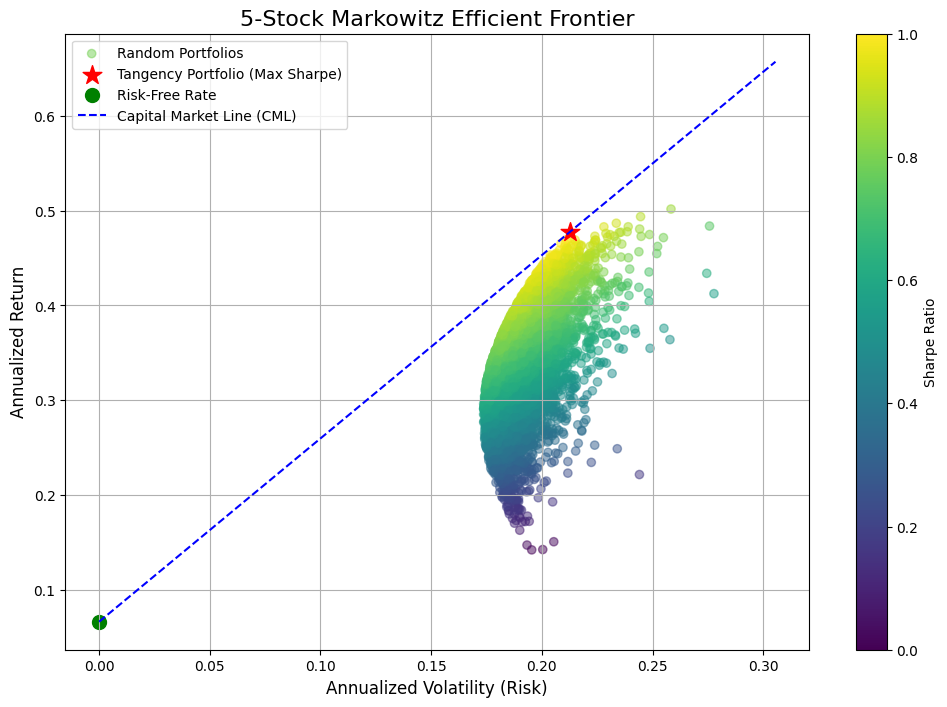

In [4]:

def get_portfolio_stats(weights, avg_returns, cov_matrix, risk_free_rate):
    port_return = np.sum(weights * avg_returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) #markowitz sigma_p formula, confirm once? seems weird
    sharpe_ratio = (port_return - risk_free_rate) / port_volatility #excess return per unit of risk
    return port_return, port_volatility, sharpe_ratio
# Computes key pf metrics like pf return, pf volatility(std dev), sharpe ratio of the pf

def neg_sharpe(weights, avg_returns, cov_matrix, risk_free_rate):
    return -get_portfolio_stats(weights, avg_returns, cov_matrix, risk_free_rate)[2] #extracts sharpe ratio of pf and negates it

print("\n--- Finding 5-Stock Tangency Portfolio ---")

num_assets = len(STOCK_COLUMNS)
avg_returns_5 = avg_annual_returns[STOCK_COLUMNS]
cov_matrix_5 = annual_cov_matrix

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1}) # constraint --> sum of weights = 1, but code line is confusing, so confirm again
bounds = tuple((0, 1) for _ in range(num_assets)) #sets bounds -> 0 <= weight_i <= 1
initial_weights = [1/num_assets] * num_assets #considers equally weighted pf

# So overall, there is NO short selling and NO leverage

opt_result = optimize.minimize(
    neg_sharpe,
    initial_weights,
    args=(avg_returns_5, cov_matrix_5, RISK_FREE_RATE),
    method='SLSQP', #sequential least squares programming --> what is this? it is standard for pf optimization
    bounds=bounds,
    constraints=constraints
) #calls SciPy's constrained optimizer to find the tangency pf, we are minimizing negative sharpe (why?, confirm once)


optimal_weights = opt_result.x # what is .x?
optimal_weights_pct = optimal_weights / np.sum(optimal_weights) #why and what?

tangency_return, tangency_vol, tangency_sharpe = get_portfolio_stats(
    optimal_weights_pct, avg_returns_5, cov_matrix_5, RISK_FREE_RATE
) # by passing the optimal (tangency) weights, we get the tangency pf i.e max sharpe ratio, we did min of negative of sharpe ratio --> why min of neg instead of max of positive?

print("Tangency Portfolio (Max Sharpe Ratio):")
print(f"  Return: {tangency_return:.4f}")
print(f"  Volatility: {tangency_vol:.4f}")
print(f"  Sharpe Ratio: {tangency_sharpe:.4f}")
print("\nOptimal Weights:")
for i, stock in enumerate(STOCK_COLUMNS):
    print(f"  {stock}: {optimal_weights_pct[i]:.2%}")


# why monte carlo? --> to plot the efficient frontier
print("\nRunning Monte Carlo simulation for plotting...")
port_returns = []
port_volatility = []
port_sharpe = []

for _ in range(10000):
    weights = np.random.random(num_assets) # we get 5 random weights
    weights /= np.sum(weights) # we divide the weights by their sum so that they all add upto 1

    ret, vol, sharpe = get_portfolio_stats(weights, avg_returns_5, cov_matrix_5, RISK_FREE_RATE)
    port_returns.append(ret)
    port_volatility.append(vol)
    port_sharpe.append(sharpe)

plt.figure(figsize=(12, 8))
plt.scatter(
    port_volatility,
    port_returns,
    c=port_sharpe,
    cmap='viridis',
    alpha=0.5,
    label='Random Portfolios'
)
plt.scatter(
    tangency_vol,
    tangency_return,
    color='red',
    marker='*',
    s=200,
    label='Tangency Portfolio (Max Sharpe)'
)
plt.scatter(
    0,
    RISK_FREE_RATE,
    color='green',
    marker='o',
    s=100,
    label='Risk-Free Rate'
)
cml_x = np.linspace(0, max(port_volatility) * 1.1, 10)
cml_y = RISK_FREE_RATE + tangency_sharpe * cml_x
plt.plot(cml_x, cml_y, color='blue', linestyle='--', label='Capital Market Line (CML)')


plt.title('5-Stock Markowitz Efficient Frontier', fontsize=16)
plt.xlabel('Annualized Volatility (Risk)', fontsize=12)
plt.ylabel('Annualized Return', fontsize=12)
plt.colorbar(label='Sharpe Ratio')
plt.legend(loc='best')
plt.grid(True)
plt.show()

C:\Users\saaketh\AppData\Local\Temp\ipykernel_26400\1453688455.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  intl_data = yf.download(INTL_TICKER, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Download complete.

--- Finding 6-Stock Tangency Portfolio ---
NEW Tangency Portfolio (6 Stocks):
  Return: 0.4304
  Volatility: 0.1712
  Sharpe Ratio: 2.1263

Optimal Weights (6 Stocks):
  Axis Bank: 0.00%
  Indigo: 24.02%
  Jubilant: 17.14%
  JK Cements: 0.00%
  Fortis: 29.89%
  AAPL: 28.95%

Running Monte Carlo simulation for 6-stock plotting...


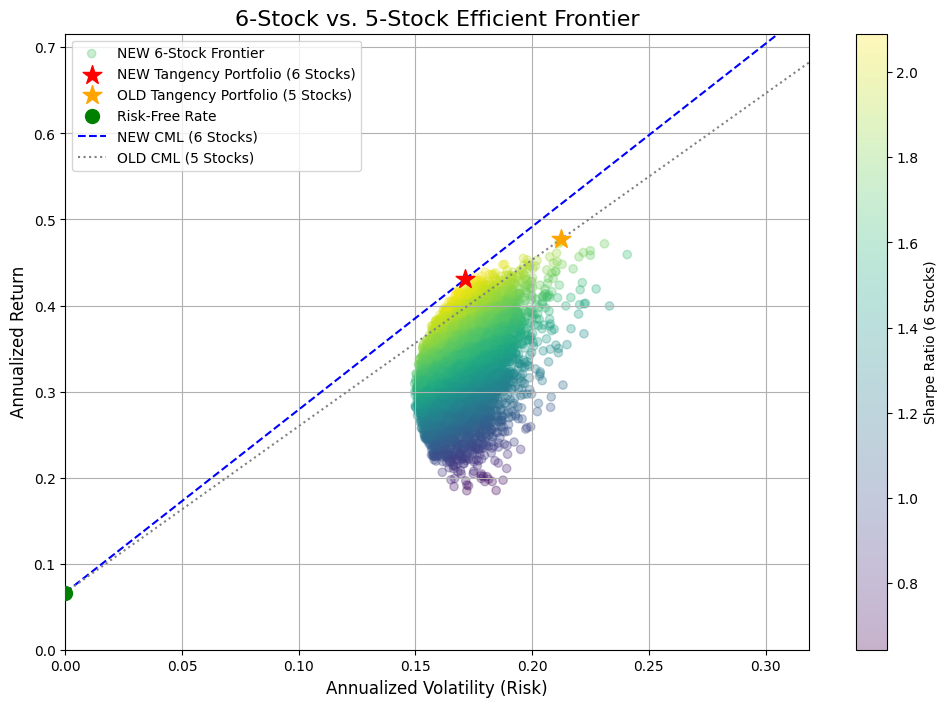


--- ANALYSIS ---
The 5-stock portfolio had a Sharpe Ratio of: 1.9336
The 6-stock portfolio had a Sharpe Ratio of: 2.1263
Finding: Adding the international stock IMPROVED the risk-adjusted return.


In [5]:
INTL_TICKER = 'AAPL'
start_date = prices_df.index.min().strftime('%Y-%m-%d')
end_date = prices_df.index.max().strftime('%Y-%m-%d')

print(f"Downloading data for {INTL_TICKER} from {start_date} to {end_date}...")
intl_data = yf.download(INTL_TICKER, start=start_date, end=end_date)
print("Download complete.")

prices_df_6 = prices_df.copy()
prices_df_6[INTL_TICKER] = intl_data['Close']

prices_df_6 = prices_df_6.ffill().bfill() #fills gaps (NaN's)

daily_returns_6 = prices_df_6.pct_change().dropna()

STOCKS_6 = STOCK_COLUMNS + [INTL_TICKER]

avg_returns_6 = (daily_returns_6[STOCKS_6].mean() * TRADING_DAYS)
cov_matrix_6 = (daily_returns_6[STOCKS_6].cov() * TRADING_DAYS)

print("\n--- Finding 6-Stock Tangency Portfolio ---")

num_assets_6 = len(STOCKS_6)

constraints_6 = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds_6 = tuple((0, 1) for _ in range(num_assets_6))
initial_weights_6 = [1/num_assets_6] * num_assets_6

opt_result_6 = optimize.minimize(
    neg_sharpe,
    initial_weights_6,
    args=(avg_returns_6, cov_matrix_6, RISK_FREE_RATE),
    method='SLSQP',
    bounds=bounds_6,
    constraints=constraints_6
)

optimal_weights_6 = opt_result_6.x
optimal_weights_pct_6 = optimal_weights_6 / np.sum(optimal_weights_6)

tangency_return_6, tangency_vol_6, tangency_sharpe_6 = get_portfolio_stats(
    optimal_weights_pct_6, avg_returns_6, cov_matrix_6, RISK_FREE_RATE
)

print("NEW Tangency Portfolio (6 Stocks):")
print(f"  Return: {tangency_return_6:.4f}")
print(f"  Volatility: {tangency_vol_6:.4f}")
print(f"  Sharpe Ratio: {tangency_sharpe_6:.4f}")
print("\nOptimal Weights (6 Stocks):")
for i, stock in enumerate(STOCKS_6):
    print(f"  {stock}: {optimal_weights_pct_6[i]:.2%}")

print("\nRunning Monte Carlo simulation for 6-stock plotting...")
port_returns_6 = []
port_volatility_6 = []
port_sharpe_6 = []

for _ in range(10000):
    weights = np.random.random(num_assets_6)
    weights /= np.sum(weights)

    ret, vol, sharpe = get_portfolio_stats(weights, avg_returns_6, cov_matrix_6, RISK_FREE_RATE)
    port_returns_6.append(ret)
    port_volatility_6.append(vol)
    port_sharpe_6.append(sharpe)

plt.figure(figsize=(12, 8))

plt.scatter(
    port_volatility_6,
    port_returns_6,
    c=port_sharpe_6,
    cmap='viridis',
    alpha=0.3,
    label='NEW 6-Stock Frontier'
)
plt.colorbar(label='Sharpe Ratio (6 Stocks)')

plt.scatter(
    tangency_vol_6,
    tangency_return_6,
    color='red',
    marker='*',
    s=200,
    label='NEW Tangency Portfolio (6 Stocks)',
    zorder=5
)
plt.scatter(
    tangency_vol,
    tangency_return,
    color='orange',
    marker='*',
    s=200,
    label='OLD Tangency Portfolio (5 Stocks)',
    zorder=5
)
plt.scatter(
    0,
    RISK_FREE_RATE,
    color='green',
    marker='o',
    s=100,
    label='Risk-Free Rate',
    zorder=5
)
plot_max_vol = max(tangency_vol_6, tangency_vol) * 1.5
cml_x_6 = np.linspace(0, plot_max_vol, 10)
cml_y_6 = RISK_FREE_RATE + tangency_sharpe_6 * cml_x_6
plt.plot(cml_x_6, cml_y_6, color='blue', linestyle='--', label='NEW CML (6 Stocks)')

cml_y = RISK_FREE_RATE + tangency_sharpe * cml_x_6
plt.plot(cml_x_6, cml_y, color='grey', linestyle=':', label='OLD CML (5 Stocks)')

plt.title('6-Stock vs. 5-Stock Efficient Frontier', fontsize=16)
plt.xlabel('Annualized Volatility (Risk)', fontsize=12)
plt.ylabel('Annualized Return', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plot_max_ret = max(tangency_return_6, tangency_return) * 1.5
plt.xlim(0, plot_max_vol)
plt.ylim(0, plot_max_ret)
plt.show()

print("\n--- ANALYSIS ---")
print(f"The 5-stock portfolio had a Sharpe Ratio of: {tangency_sharpe:.4f}")
print(f"The 6-stock portfolio had a Sharpe Ratio of: {tangency_sharpe_6:.4f}")
if tangency_sharpe_6 > tangency_sharpe:
    print("Finding: Adding the international stock IMPROVED the risk-adjusted return.")
else:
    print("Finding: Adding the international stock DID NOT improve the risk-adjusted return.")


--- Beta and CAPM Calculations ---
Using Market Return (Nifty 50): 0.0566
Using Risk-Free Rate: 0.0664

--- Analyzing: Axis Bank ---
  Beta: 1.1050
  CAPM Required Return: 0.0556


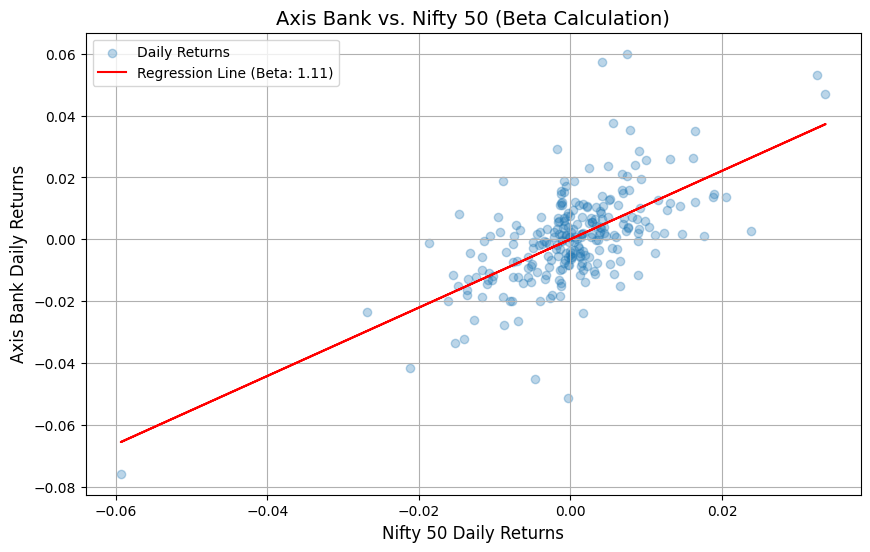

--- Analyzing: Indigo ---
  Beta: 0.9305
  CAPM Required Return: 0.0573


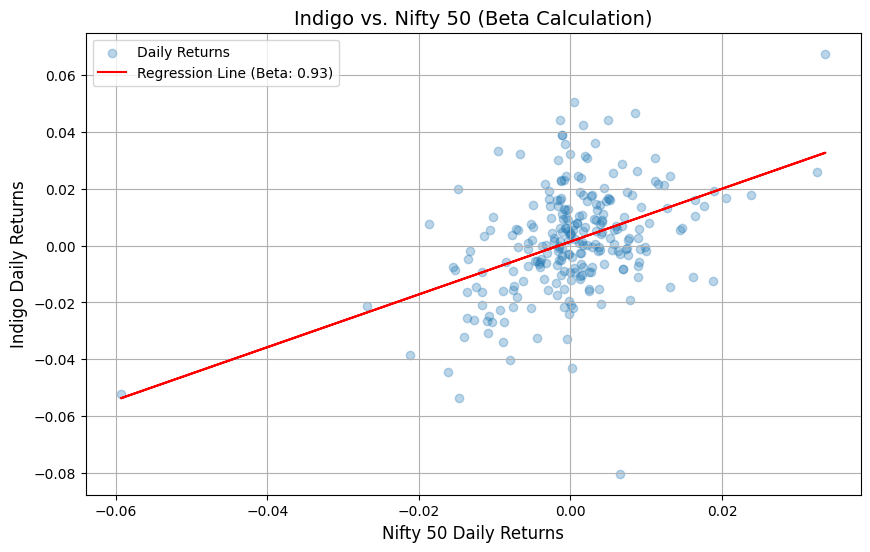

--- Analyzing: Jubilant ---
  Beta: 0.7238
  CAPM Required Return: 0.0593


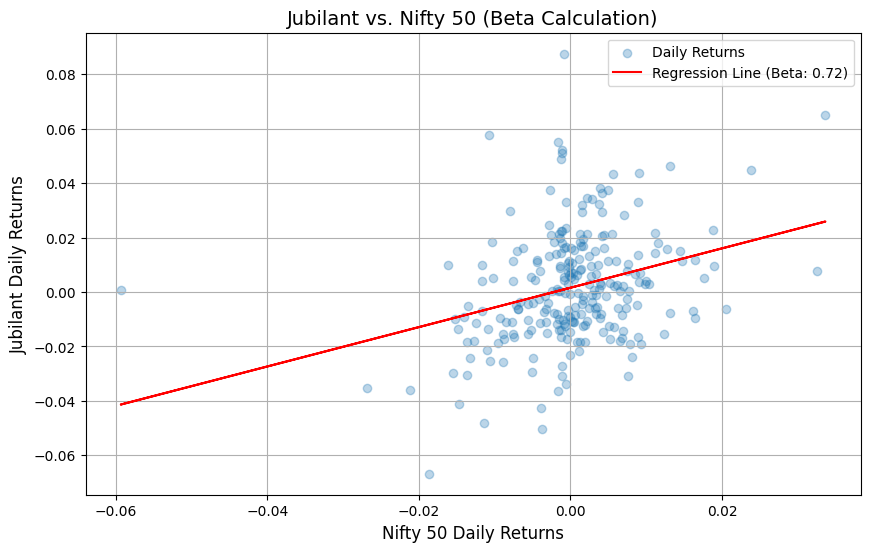

--- Analyzing: JK Cements ---
  Beta: 0.9489
  CAPM Required Return: 0.0571


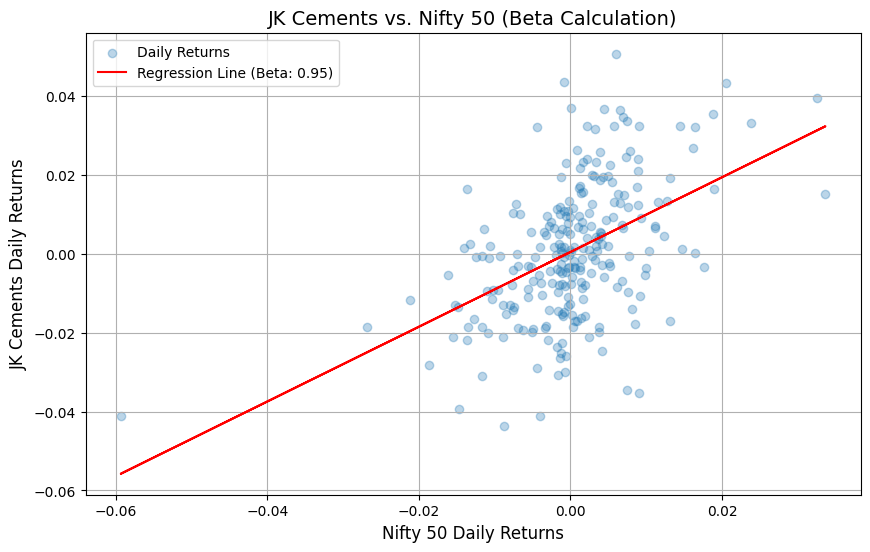

--- Analyzing: Fortis ---
  Beta: 0.6194
  CAPM Required Return: 0.0604


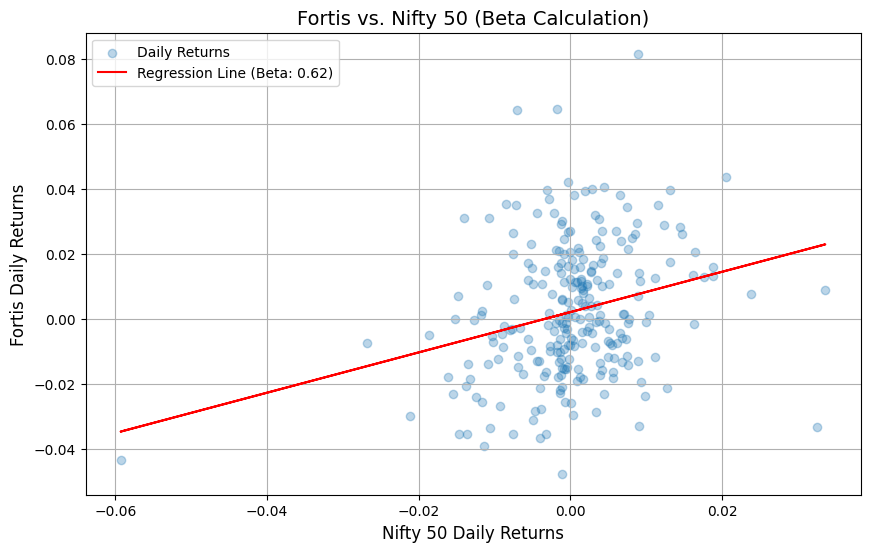


--- FINAL SUMMARY: CAPM vs. Actual ---
|            |   Beta |   CAPM Return |   Actual Avg Return |
|:-----------|-------:|--------------:|--------------------:|
| Axis Bank  | 1.1050 |        0.0556 |              0.0757 |
| Indigo     | 0.9305 |        0.0573 |              0.4166 |
| Jubilant   | 0.7238 |        0.0593 |              0.4382 |
| JK Cements | 0.9489 |        0.0571 |              0.1807 |
| Fortis     | 0.6194 |        0.0604 |              0.5485 |

--- Analysis Guide ---
Use this table for your report:
- If 'Actual Avg Return' > 'CAPM Return', the stock was 'undervalued' (it performed better than its risk predicted).
- If 'Actual Avg Return' < 'CAPM Return', the stock was 'overvalued' (it performed worse than its risk predicted).


In [6]:
print("\n--- Beta and CAPM Calculations ---")

market_return = avg_annual_returns[INDEX_COLUMN]
print(f"Using Market Return ({INDEX_COLUMN}): {market_return:.4f}")
print(f"Using Risk-Free Rate: {RISK_FREE_RATE:.4f}\n")

capm_results = {}

for stock in STOCK_COLUMNS:
    print(f"--- Analyzing: {stock} ---")

    Y = daily_returns[stock]
    X = daily_returns[INDEX_COLUMN]

    X_with_const = sm.add_constant(X)

    model = sm.OLS(Y, X_with_const).fit()

    beta = model.params[INDEX_COLUMN]

    print(f"  Beta: {beta:.4f}")

    capm_return = RISK_FREE_RATE + beta * (market_return - RISK_FREE_RATE)

    print(f"  CAPM Required Return: {capm_return:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(X, Y, alpha=0.3, label='Daily Returns')
    plt.plot(X, model.fittedvalues, color='red', label=f'Regression Line (Beta: {beta:.2f})')
    plt.title(f'{stock} vs. {INDEX_COLUMN} (Beta Calculation)', fontsize=14)
    plt.xlabel(f'{INDEX_COLUMN} Daily Returns', fontsize=12)
    plt.ylabel(f'{stock} Daily Returns', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

    capm_results[stock] = {
        'Beta': beta,
        'CAPM Return': capm_return,
        'Actual Avg Return': avg_annual_returns[stock]
    }
print("\n--- FINAL SUMMARY: CAPM vs. Actual ---")
summary_df = pd.DataFrame(capm_results).T
print(summary_df.to_markdown(floatfmt=".4f"))

print("\n--- Analysis Guide ---")
print("Use this table for your report:")
print("- If 'Actual Avg Return' > 'CAPM Return', the stock was 'undervalued' (it performed better than its risk predicted).")
print("- If 'Actual Avg Return' < 'CAPM Return', the stock was 'overvalued' (it performed worse than its risk predicted).")